In [170]:
%gui qt5
import napari
import ants
#from dask_image.imread import imread
import tifffile
import numpy as np
import matplotlib.pyplot as plt
import skimage 

from IPython.display import clear_output


import h5py
import scipy 

In [2]:
#Requires enviroments: file:///mp/nvme/ZMIA-Zebrafish-Multimodal-Image-Analysis/envs/zmia-env.yml
#That can be activated using: conda activate /mp/nvme/ZMIA-Zebrafish-Multimodal-Image-Analysis/envs/zmia-env/


In [31]:
# Specify path and load images using tiff-file library:
path_with_files='/home/panos/nvme/FISH_DATA/cs-ii-14_corban-swain-shared-zmia-data/ToTestRegistration/'
ImFunction=tifffile.imread([path_with_files + 'TwoPhoton_Function.tif'])
ImAnatomy=tifffile.imread([path_with_files + 'TwoPhoton_Anatomy.tif'])
ImAtlas=np.flip(tifffile.imread([path_with_files + 'zbrain_Elavl3-GCaMP5G.tif']),axis=0)  
ImAtlasHB=np.flip(tifffile.imread([path_with_files + 'zbrain_Elavl3-H2BRFP.tif']),axis=0)  
ImIHC=tifffile.imread([path_with_files + 'Confocal_IHC.tif'])    


In [4]:
#Display dimension to confirm proper loading and educate further previews
display(['Func:' + str(ImFunction.shape) + 'Anat' + str(ImAnatomy.shape) + 'Atlas' + str(ImAtlas.shape) + 'IHC'+ str(ImIHC.shape)])

['Func:(500, 38, 512, 512)Anat(192, 2048, 3521)Atlas(138, 621, 1406)IHC(6, 4, 3892, 5735)']

In [32]:
#Prepare z-2D projections to navigate data
ImFunctionMIP=np.amax(np.mean(ImFunction,axis=0),0) #first estimate the temporal mean
ImAnatomyMIP=np.amax(ImAnatomy,0)
ImAtlasMIP=np.amax(ImAtlas,0)
ImAtlasHBMIP=np.amax(ImAtlasHB,0)
ImIHCMIP=np.amax(ImIHC[:,2,:,:],0) #select DAPI channel.

#Prepare x-2D projections to navigate data
ImFunctionMIPy=np.amax(np.mean(ImFunction,axis=0),1) 
ImAnatomyMIPy=np.amax(ImAnatomy,1)
ImAtlasMIPy=np.amax(ImAtlas,1)
ImAtlasHBMIPy=np.amax(ImAtlasHB,1)
ImIHCMIPy=np.amax(ImIHC[:,2,:,:],1) 

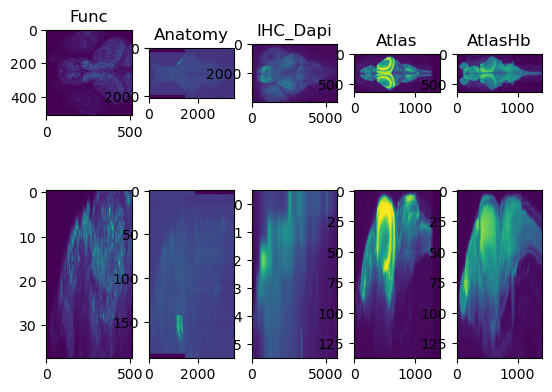

In [33]:
fig, axs = plt.subplots(2, 5)
axs[0, 0].imshow(ImFunctionMIP) ; axs[0, 0].set_title('Func')
axs[0, 1].imshow(pow(ImAnatomyMIP,0.3)) ; axs[0, 1].set_title('Anatomy')
axs[0, 2].imshow(ImIHCMIP); axs[0, 2].set_title('IHC_Dapi')
axs[0, 3].imshow(ImAtlasMIP) ; axs[0, 3].set_title('Atlas') 
axs[0, 4].imshow(ImAtlasHBMIP) ; axs[0, 4].set_title('AtlasHb') 


axs[1, 0].imshow(ImFunctionMIPy,aspect='auto') ; 
axs[1, 1].imshow(pow(ImAnatomyMIPy,0.3),aspect='auto') ; 
axs[1, 2].imshow(ImIHCMIPy,aspect='auto'); 
axs[1, 3].imshow(ImAtlasMIPy,aspect='auto') ; 
axs[1, 4].imshow(ImAtlasHBMIPy,aspect='auto') ; 
#note that the aspect ration of x-projections is uneven for better visualation

In [30]:
#Define a "universal" registration funtion, to minimize typing. twicking might be necessary
def reg(template, moving):
    ## Assing arrays to the "fixed" "moved" variables and convert them from numpy to ants format
    fixed=ants.from_numpy(template.astype(float)) 
    moving = ants.from_numpy( moving.astype(float) )


    ## perform the estimation of the needed registration [TIMECONSUMING]
    #  aff_sampling=0 means no randomness for registration
    #mytx = ants.registration(fixed=fixed , moving=moving ,type_of_transform = 'Affine',aff_metric='GC')
    mytx = ants.registration(fixed=fixed , moving=moving ,type_of_transform = 'Similarity',syn_metric='demons',syn_sampling=16, reg_iterations=(125, 25, 5, 0))
    mywarpedimage = ants.apply_transforms( fixed=fixed, moving=moving,transformlist=mytx['fwdtransforms'] )
  
    return  mywarpedimage, mytx




Parameters:	
fixed (ANTsImage) – fixed image to which we register the moving image.
moving (ANTsImage) – moving image to be mapped to fixed space.
type_of_transform (string) – A linear or non-linear registration type. Mutual information metric by default. See Notes below for more.
initial_transform (list of strings (optional)) – transforms to prepend
outprefix (string) – output will be named with this prefix.
mask (ANTsImage (optional)) – mask the registration.
grad_step (scalar) – gradient step size (not for all tx)
flow_sigma (scalar) – smoothing for update field
total_sigma (scalar) – smoothing for total field
aff_metric (string) – the metric for the affine part (GC, mattes, meansquares)
aff_sampling (scalar) – the nbins or radius parameter for the syn metric
syn_metric (string) – the metric for the syn part (CC, mattes, meansquares, demons)
syn_sampling (scalar) – the nbins or radius parameter for the syn metric
reg_iterations (list/tuple of python:integers) – vector of iterations for syn. we will set the smoothing and multi-resolution parameters based on the length of this vector.
verbose (boolean) – request verbose output (useful for debugging)
kwargs (keyword args) – extra arguments


typeofTransform can be one of:
“Translation”: Translation transformation.
“Rigid”: Rigid transformation: Only rotation and translation.
“Similarity”: Similarity transformation: scaling, rotation and translation.
“QuickRigid”: Rigid transformation: Only rotation and translation.
May be useful for quick visualization fixes.’
“DenseRigid”: Rigid transformation: Only rotation and translation.
Employs dense sampling during metric estimation.’
“BOLDRigid”: Rigid transformation: Parameters typical for BOLD to
BOLD intrasubject registration’.’
“Affine”: Affine transformation: Rigid + scaling.
“AffineFast”: Fast version of Affine.
“BOLDAffine”: Affine transformation: Parameters typical for BOLD to
BOLD intrasubject registration’.’
“TRSAA”: translation, rigid, similarity, affine (twice). please set
regIterations if using this option. this would be used in cases where you want a really high quality affine mapping (perhaps with mask).
“ElasticSyN”: Symmetric normalization: Affine + deformable
transformation, with mutual information as optimization metric and elastic regularization.
“SyN”: Symmetric normalization: Affine + deformable transformation,
with mutual information as optimization metric.
“SyNRA”: Symmetric normalization: Rigid + Affine + deformable
transformation, with mutual information as optimization metric.
“SyNOnly”: Symmetric normalization: no initial transformation,
with mutual information as optimization metric. Assumes images are aligned by an inital transformation. Can be useful if you want to run an unmasked affine followed by masked deformable registration.
“SyNCC”: SyN, but with cross-correlation as the metric.
“SyNabp”: SyN optimized for abpBrainExtraction.
“SyNBold”: SyN, but optimized for registrations between BOLD and T1 images.
“SyNBoldAff”: SyN, but optimized for registrations between BOLD
and T1 images, with additional affine step.
“SyNAggro”: SyN, but with more aggressive registration
(fine-scale matching and more deformation). Takes more time than SyN.
“TVMSQ”: time-varying diffeomorphism with mean square metric
“TVMSQC”: time-varying diffeomorphism with mean square metric for very large deformation

In [8]:
# Anatomy-->Atlas
ImAnatomyREGants,mytx=reg(ImAtlas,ImAnatomy)
ImAnatomyREG=ImAnatomyREGants.numpy()

Text(0.5, 1.0, 'Atlas')

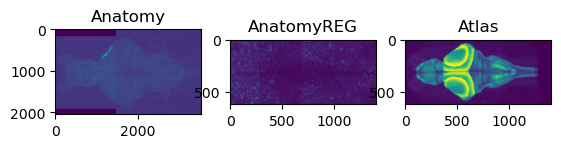

In [9]:
fig, (ax0, ax1,ax2) = plt.subplots(1,3)
ax0.imshow(pow(ImAnatomyMIP,0.3)) ; ax0.set_title('Anatomy')
ax1.imshow((np.amax(ImAnatomyREG,0))) ; ax1.set_title('AnatomyREG')
ax2.imshow(ImAtlasMIP) ; ax2.set_title('Atlas') 

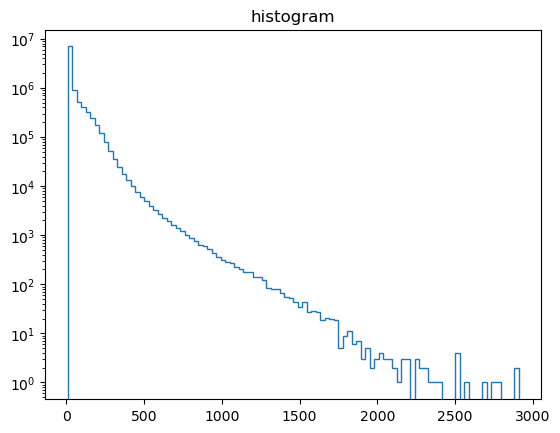

In [143]:
# Convert 2D data to 1D and plot historgram on (logarithmic y-axis)
img=ImFunctionTM

rows,cols,colors = img.shape # gives dimensions
img_size=rows*cols*colors
img_1D_vector = img.reshape(img_size)


plt.hist(img_1D_vector,bins=100, histtype="step") 
plt.title("histogram") 
plt.yscale('log')
plt.show()

In [11]:
#Clip the data value range to block super low/high value from driving registration
ImAnatomyClipped=np.clip(ImAnatomy,20,100)

In [ ]:
#Estimate Gaussian Smoothed version of the data
ImAnatomyClippedSmooth=skimage.filters.gaussian(ImAnatomyClipped,sigma=[10, 50, 50])

In [40]:
## Local median filtering

# TODO - why is the resize being performed twice
ImAnatomyClippedSmoothSmall = skimage.transform.resize(ImAnatomyClipped, (ImAnatomyClippedSmooth.shape[0] // 5,
                                                              ImAnatomyClippedSmooth.shape[1] // 5,
                                                              ImAnatomyClippedSmooth.shape[2] // 5),
                                     anti_aliasing=True)

FootprintSmall = np.ones([5,10,10]) #this is the kernel of the mean-filter
ImAnatomyClippedMeanSmall = skimage.filters.median(ImAnatomyClippedSmoothSmall, FootprintSmall)


ImAnatomyClippedMean = skimage.transform.resize(ImAnatomyClippedMeanSmall, (ImAnatomyClippedSmooth.shape[0] ,
                                                       ImAnatomyClippedSmooth.shape[1]//2 ,
                                                       ImAnatomyClippedSmooth.shape[2]//2 ),
                                     anti_aliasing=True)

Text(0.5, 1.0, 'MedFilt3D')

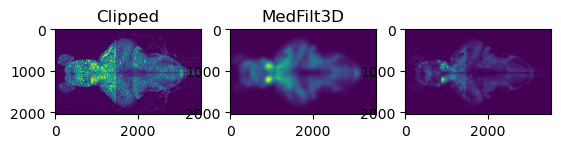

In [14]:
fig, (ax0, ax1, ax2) = plt.subplots(1,3)
ax0.imshow((np.amax(ImAnatomyClipped,0))); ax0.set_title('Clipped')
ax1.imshow((np.amax(ImAnatomyClippedSmooth,0))) ; ax1.set_title('Smooth')
ax2.imshow((np.amax(ImAnatomyClippedMean,0))) ; ax2.set_title('MedFilt3D')

In [ ]:
# Perform registration using the the clipped version
ImAnatomyS_REGants,mytx=reg(ImAtlasHB,ImAnatomyClippedMean )
ImAnatomyS_REG=ImAnatomyS_REGants.numpy()

Text(0.5, 1.0, 'Atlas')

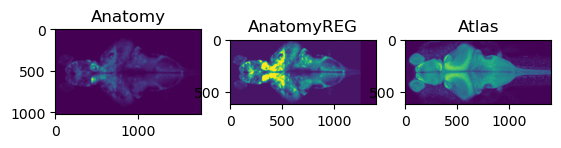

In [84]:
fig, (ax0, ax1,ax2) = plt.subplots(1,3)
ax0.imshow((np.amax(ImAnatomyClippedMean,0))) ; ax0.set_title('AnatomySmoothed')
ax1.imshow((np.amax(np.clip(ImAnatomyS_REG,0.0003,0.0004),0))) ; ax1.set_title('AnatomySmoothedREG')
ax2.imshow(ImAtlasHBMIP) ; ax2.set_title('Atlas') 

In [123]:
#Apply registration to RAW data, after applying the same pre-scaling that worked for the clipped-version
ImAnatomyResized=skimage.transform.resize(ImAnatomy,(ImAnatomy.shape[0],ImAnatomy.shape[1]//2 ,
                                                     ImAnatomy.shape[2]//2 ),anti_aliasing=True)
ImAnatomyREGants = ants.apply_transforms( fixed=ants.from_numpy(ImAtlasHB.astype(float)) ,
                                         moving=ants.from_numpy(ImAnatomyResized.astype(float)),
                                         transformlist=mytx['fwdtransforms'] )
ImAnatomyREG=ImAnatomyREGants.numpy()

Text(0.5, 1.0, 'Atlas')

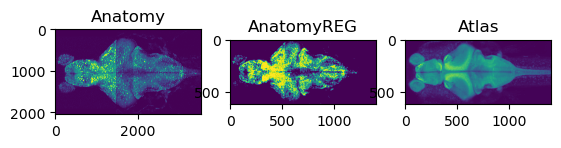

In [128]:
fig, (ax0, ax1,ax2) = plt.subplots(1,3)
ax0.imshow((np.amax(np.clip(ImAnatomy,20,100),0))) ; ax0.set_title('Anatomy')
ax1.imshow((np.amax(np.clip(ImAnatomyREG,0.0003,0.0005),0))) ; ax1.set_title('AnatomyREG')
ax2.imshow(ImAtlasHBMIP) ; ax2.set_title('Atlas') 

In [129]:
## Experimenting With Functional Data: 

UsageError: Cell magic `%%` not found.


In [156]:
ImFunctionTM=(np.mean(ImFunction,axis=0))

In [157]:
skimage.transform.resize(ImAnatomy,(ImAnatomy.shape[0],ImAnatomy.shape[1]//2 ,
                                                     ImAnatomy.shape[2]//2 ),anti_aliasing=True)
ImFun2Use=skimage.filters.gaussian(
    np.clip(
        skimage.transform.resize(ImFunctionTM,(ImFunctionTM.shape[0]*5,ImFunctionTM.shape[1] ,
                                                     ImFunctionTM.shape[2] ),anti_aliasing=True),
        150,1000),
    sigma=[5, 15, 15])

In [158]:
ImFunctionTM_REGants,mytx=reg(ImAtlasHB,ImFun2Use)
ImFunctionTM_REG=ImFunction_REGants.numpy()

Text(0.5, 1.0, 'Atlas')

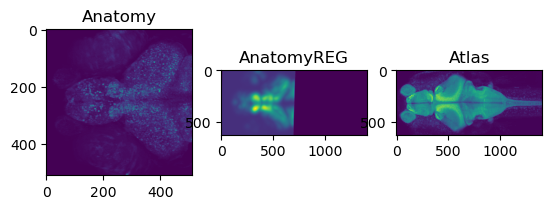

In [159]:
fig, (ax0, ax1,ax2) = plt.subplots(1,3)
ax0.imshow((np.amax(ImFunctionTM,0))) ; ax0.set_title('Function')
ax1.imshow((np.amax(np.clip(ImFunctionTM_REG,120,1000),0))) ; ax1.set_title('FunctionREG')
ax2.imshow(ImAtlasHBMIP) ; ax2.set_title('Atlas') 

In [203]:
ImFunctionREG = list()
for i_t in range( ( ImFunction.shape[0] ) ): 
    display(i_t)

    clear_output(wait=True)
    this_frame=np.squeeze(ImFunction[i_t,::,::,::])
    this_frame_scaled=skimage.transform.resize(this_frame,(this_frame.shape[0]*5,this_frame.shape[1],
                                                     this_frame.shape[2] ),anti_aliasing=True)
    
    
    this_frame_reg_ants = ants.apply_transforms( fixed=ants.from_numpy(ImAtlasHB.astype(float)) ,
                                         moving=ants.from_numpy(this_frame_scaled.astype(float)),
                                         transformlist=mytx['fwdtransforms'] )
    this_frame_reg=this_frame_reg_ants.numpy()
    ImFunctionREG.append( this_frame_reg )
ImFunctionREG=np.array(ImFunctionREG)   



499

In [205]:
#d=load_sparse_matrix(masks['MaskDatabaseOutlines']) #this does not actually load the data
masks = h5py.File('//mp/nvme/MaskDatabase.mat', 'r')
dataM = masks['MaskDatabase']['data']
ir = masks['MaskDatabase']['ir']
jc = masks['MaskDatabase']['jc']
Msparse = scipy.sparse.csc_matrix((dataM, ir, jc),
                                  shape=(int(np.array(masks['height']))*
                                         int(np.array(masks['width']))*
                                         int(np.array(masks['Zs'])),294))
M=Msparse.toarray()
M=np.reshape(M,(int(np.array(masks['Zs'])),
                int(np.array(masks['width'])),
                int(np.array(masks['height']))
                ,294))


In [212]:
display(ImFunctionREG.shape)
display(M.shape)

(500, 138, 621, 1406)

(138, 621, 1406, 294)

In [ ]:
## EXTRACTING SINGALS
Mreg=M
A=ImFunctionREG
F_S = None;
F_Smean=np.zeros((Mreg.shape[0],A.shape[0]))
F_Smedian=np.zeros((Mreg.shape[0],A.shape[0]))
F_Smax=np.zeros((Mreg.shape[0],A.shape[0]))
F_Smin=np.zeros((Mreg.shape[0],A.shape[0]))
F_Sstd=np.zeros((Mreg.shape[0],A.shape[0]))


for i_label in range(Mreg.shape[0]): #range(294):
    clear_output(wait=True)
    display(i_label)
    Mask2Use=np.squeeze(Mreg[::,::,::,i_label]);
    F_Smean[i_label][i_t]=scipy.ndimage.mean(A, labels=Mask2Use, index=1)
    F_Smax[i_label][i_t]=scipy.ndimage.maximum(A, labels=Mask2Use, index=1)
    F_Smin[i_label][i_t]=scipy.ndimage.minimum(A, labels=Mask2Use, index=1)
    F_Smedian[i_label][i_t]=scipy.ndimage.median(A, labels=Mask2Use, index=1)
    F_Sstd[i_label][i_t]=scipy.ndimage.standard_deviation(A, labels=Mask2Use, index=1)

33

In [ ]:
fig = plt.figure()
plt.gray()
ax1=fig.add_subplot(211); ax2=fig.add_subplot(212); 
ax1.imshow(M_Smean/np.mean(M_Smean+1,1)[:,None]);     
ax2.plot(((M_Smean/np.mean(M_Smean+1,1)[:,None]).conj().T));     